In [30]:
from os import listdir
from os.path import isfile, join
import numpy as np
import cv2
import pickle
import pyenf
import scipy.io.wavfile
import math
from scipy.fftpack import fftshift
import matplotlib.pyplot as plt
import librosa
from skimage.util import img_as_float
from skimage.segmentation import slic
from scipy.stats.stats import pearsonr

In [31]:
def correlation_vector(ENF_signal1, ENF_signal2, window_size, shift_size):
    correlation_ENF = []
    length_of_signal = min(len(ENF_signal1), len(ENF_signal2))
    total_windows = math.ceil(( length_of_signal - window_size + 1) / shift_size)
    rho = np.zeros((1,total_windows))
    for i in range(0,total_windows):
        enf_sig1 = ENF_signal1[i * shift_size: i * shift_size + window_size]
        enf_sig2 = ENF_signal2[i * shift_size: i * shift_size + window_size]
        enf_sig1 = np.reshape(enf_sig1, (len(enf_sig1),))
        enf_sig2 = np.reshape(enf_sig2,(len(enf_sig2), ))
        r,p = pearsonr(enf_sig1, enf_sig2)
        rho[0][i] = r
    return rho,total_windows


In [32]:
folder = "../input/"
#onlyfiles = [f for f in listdir(folder) if isfile(join(folder, f))]
power_rec_name = "newamp_15min_pwr.wav" #"power_parallel.wav" 
audio_rec_name = "newamp_15min_aud.wav" # "audio_parallel.wav" #
power_filepath = folder + power_rec_name
audio_filepath = folder + audio_rec_name

In [48]:
#parameters for the STFT algorithm
fs = 1000  # downsampling frequency
nfft = 8192
frame_size = 2  # change it to 6 for videos with large length recording
overlap = 0

power_signal_filename = power_filepath
audio_signal_filename = audio_filepath
power_signal0, fs = librosa.load(power_signal_filename, sr=fs)  # loading the power ENF data
audio_signal0, fs = librosa.load(audio_signal_filename, sr=fs)  # loading the power ENF data

cmpr_len = min(len(power_signal0),len(audio_signal0))

#initialize the class object for the ENF.

# 60 for 15 mins
power_signal_object = pyenf.pyENF(signal0=power_signal0[0:cmpr_len], fs=fs, nominal=60, harmonic_multiples=1, duration=.1,
                                  strip_index=0, frame_size_secs=frame_size, nfft=nfft, overlap_amount_secs=overlap)
power_spectro_strip, power_frequency_support = power_signal_object.compute_spectrogam_strips()
power_weights = power_signal_object.compute_combining_weights_from_harmonics()
power_OurStripCell, power_initial_frequency = power_signal_object.compute_combined_spectrum(power_spectro_strip,
                                                                                            power_weights,
                                                                                            power_frequency_support)
power_ENF = power_signal_object.compute_ENF_from_combined_strip(power_OurStripCell, power_initial_frequency)

In [54]:
#fs = 1000  # downsampling frequency
#nfft = 8192
#frame_size = 2  # change it to 6 for videos with large length recording
#overlap = 0

#audio_signal_filename = audio_filepath
#audio_signal0, fs = librosa.load(audio_signal_filename, sr=fs)  # loading the power ENF data

#initialize the class object for the ENF.

audio_signal_object = pyenf.pyENF(signal0=audio_signal0[0:cmpr_len], fs=fs, nominal=300, harmonic_multiples=5, duration=.1,
                                strip_index=0, frame_size_secs=frame_size, nfft=nfft, overlap_amount_secs=overlap)
audio_spectro_strip, audio_frequency_support = audio_signal_object.compute_spectrogam_strips()
audio_weights = audio_signal_object.compute_combining_weights_from_harmonics()
audio_OurStripCell, audio_initial_frequency = audio_signal_object.compute_combined_spectrum(audio_spectro_strip,
                                                                                            audio_weights,
                                                                                            audio_frequency_support)
audio_ENF = audio_signal_object.compute_ENF_from_combined_strip(audio_OurStripCell, audio_initial_frequency)

/home/adilet/miniconda3/envs/enfenv/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [50]:
print("Length of power signal")
print(len(power_ENF))
print("Length of audio signal")
print(len(audio_ENF))

Length of power signal
600
Length of audio signal
600


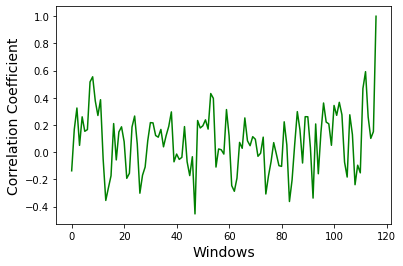

In [51]:
rho,total_windows = correlation_vector(power_ENF, audio_ENF, 20, 5)
plt.figure()
plt.plot(rho[0],'g')
plt.ylabel('Correlation Coefficient', fontsize=14)
plt.xlabel('Windows', fontsize=14)
#plt.savefig('../output/parallel-new-amp-vol10.png')
plt.show()